In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%cd /data/

/data


In [3]:
import torch
from src.utils.datasets.ggimages import OpenImage
from src.utils.datasets.transform import RandomHorizontalFlip, Resize, Compose, XyToCenter
import torchvision.transforms as transforms
from src.utils.display.images import imshow, result_show
from torch.utils.data import DataLoader
from src.utils.datasets.adapter import convert_data_v3
import numpy as np
from src.network.yolo import Yolo
from src.config import VOC_ANCHORS, RATIOS
from src.utils.process_boxes import preprocess_true_boxes
from src.config import IOU_THRESHOLD, TENSORBOARD_PATH
from tensorboardX import SummaryWriter
from datetime import datetime
from functools import partial



general_transform = Compose([
    Resize((416, 416)),
    XyToCenter()
])


transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [
                                     0.229, 0.224, 0.225])
            ])

In [4]:
batch_size = 1

ds = OpenImage('/data/data', 'OpenImage', general_transform=general_transform, transform=transform)

train_data_loader = DataLoader(ds, batch_size=batch_size, shuffle=True, collate_fn=partial(lambda p, x: convert_data_v3(x, p), RATIOS), num_workers=1, drop_last=True)

tensor([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 2, 0, 0],
         [0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 2, 0, 0],
         [0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 2, 0, 0],
         [0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 2, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 2, 0, 0]],

        [[0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

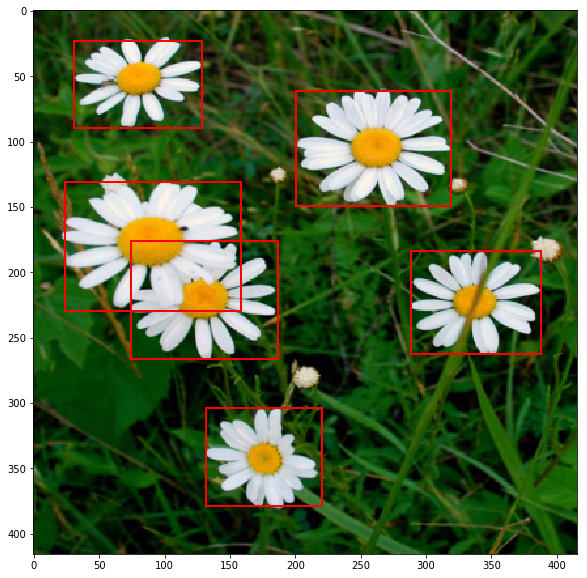

In [5]:
for step, blobs in enumerate(train_data_loader):
    if step > 0:
        break
    batch_tensor, batch_boxes, mask_dict, im_info, img_names = blobs
    detectors_mask = mask_dict['detector_mask_32']
    matching_true_boxes = mask_dict['matching_true_boxes_32']
    print(matching_true_boxes[:,:, 4:, ].argmax(dim=2))
    print(detectors_mask)
    
    for k in range(batch_tensor.shape[0]):
        current_im_info = im_info[0]
        tmp = batch_boxes[k] * torch.Tensor([current_im_info[0], current_im_info[1], current_im_info[0], current_im_info[1], 1])
        tmp = tmp.numpy()        
        between = tmp[:, 2:4] / 2        
        xy = tmp[:, :2]
        xy_min = xy - between
        xy_max = xy + between
        imshow(batch_tensor[k], gt_boxes=np.hstack((xy_min, xy_max)))    